2.3: What happens when gradient is almost zero

In [20]:
!pip install autograd_lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
torch.manual_seed(42)
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib


from torch.utils.data import DataLoader, TensorDataset

In [22]:
Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 
num_of_rows = 300
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

In [23]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x
    
    
    def training_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                
        loss = loss_fn(out, targets)   
        return loss
    
    def validation_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                
        loss = loss_fn(out, targets)    
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        return {'val_loss': epoch_loss.item()}
    
    def train_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 
        loss = loss_fn(out, targets)    
        return {'train_loss': loss.detach()}

    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        return {'train_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))        

In [24]:
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) 

    return grad_mean

def save_activations(layer, A, _):
    activations[layer] = A

def compute_hess(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) 
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)
    
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []
    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.symeig(h).eigenvalues 
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) 

    return ratio_mean

In [25]:
def get_norm_minimal_ratio(model,criterion):

    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio
    
    return result

In [26]:
def evaluate(model,loss_fn, val_loader):
    outputs = [model.validation_step(batch,loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model,loss_fn, train_loader):
    outputs = [model.train_step(batch,loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all=0.0
    grad =0
    
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            
        grad_all+=grad
        
    grad_norm=grad_all ** 0.5
    return grad_norm

def fit(epochs, lr, model, data_loader, criterion,opt_func):
    history = []
    comparing_epoch_loss =1000.0
    grad_norm_per_epoch={}
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        optimizer.zero_grad()   
        prediction = model(X)
        loss = criterion(prediction, Y)  
        loss.backward()  
        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model,criterion)
        optimizer.step() 
        optimizer.zero_grad()
        result = evaluate(model,criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
        if epoch == 900:
            comparing_epoch_loss= result["val_loss"]
    
    return history,grad_norm_per_epoch,model    

In [27]:
num_of_rows = 300
lr = 0.0004
gamma_lr_scheduler = 0.1 
weight_decay = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2500
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
filename = criterion_name+ optimizer_name+".png"
grad_norm_name = "_grad_norm_name1_2.png"
result_folder_name = "result3/"

In [28]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2000
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
input_size=1
output_size=1
model= MathRegressor()


In [29]:
autograd_lib.register(model)
activations = defaultdict(int)
hess = defaultdict(float)
result_1 = evaluate(model,criterion,data_loader)
result_1
           

{'val_loss': 0.17534957826137543}

In [30]:
class M1(torch.nn.Module):
    def __init__(self,):
        super(M1, self).__init__()
        self.hidden1 = torch.nn.Linear(1, 5)  
        self.hidden2 = torch.nn.Linear(5, 10)
        self.hidden3 = torch.nn.Linear (10, 10)
        self.hidden4 = torch.nn.Linear (10, 10)
        self.hidden5 = torch.nn.Linear (10, 10)
        self.hidden6 = torch.nn.Linear (10, 10)
        self.hidden7 = torch.nn.Linear (10,5)
        self.predict = torch.nn.Linear(5, 1)  
       
        
    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))   
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        x = F.leaky_relu(self.hidden4(x))
        x = F.leaky_relu(self.hidden5(x))
        x = F.leaky_relu(self.hidden6(x))
        x = F.leaky_relu(self.hidden7(x))
        x = self.predict(x)               
        return x

model_1 = M1()

In [31]:
filename = criterion_name+ optimizer_name+".png"
train,target = X,Y


In [33]:
history_1,grad_norm_1,model_1  = fit(num_epochs, lr, model, data_loader, criterion,optimizer)

<ipython-input-24-c3bbe8efcc41>:41: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2794.)
  h_eig = torch.symeig(h).eigenvalues


gradient norm: 1.3272387273609638, minimum ratio: 0.69140625
Epoch [0], val_loss: 0.1842
gradient norm: 1.3935913108289242, minimum ratio: 0.734375
Epoch [1], val_loss: 0.1934
gradient norm: 1.4600119907408953, minimum ratio: 0.71875
Epoch [2], val_loss: 0.2031
gradient norm: 1.5264999717473984, minimum ratio: 0.72265625
Epoch [3], val_loss: 0.2132
gradient norm: 1.5930302571505308, minimum ratio: 0.703125
Epoch [4], val_loss: 0.2238
gradient norm: 1.6596167162060738, minimum ratio: 0.7421875
Epoch [5], val_loss: 0.2348
gradient norm: 1.726239413022995, minimum ratio: 0.7109375
Epoch [6], val_loss: 0.2463
gradient norm: 1.792908288538456, minimum ratio: 0.72265625
Epoch [7], val_loss: 0.2581
gradient norm: 1.8596301805227995, minimum ratio: 0.72265625
Epoch [8], val_loss: 0.2705
gradient norm: 1.9263950139284134, minimum ratio: 0.734375
Epoch [9], val_loss: 0.2833
gradient norm: 1.9932358302175999, minimum ratio: 0.73828125
Epoch [10], val_loss: 0.2965
gradient norm: 2.060106359422207,

In [34]:
grad_norm_1

{0: {'grad_norm': 1.3272387273609638, 'ratio': 0.69140625},
 1: {'grad_norm': 1.3935913108289242, 'ratio': 0.734375},
 2: {'grad_norm': 1.4600119907408953, 'ratio': 0.71875},
 3: {'grad_norm': 1.5264999717473984, 'ratio': 0.72265625},
 4: {'grad_norm': 1.5930302571505308, 'ratio': 0.703125},
 5: {'grad_norm': 1.6596167162060738, 'ratio': 0.7421875},
 6: {'grad_norm': 1.726239413022995, 'ratio': 0.7109375},
 7: {'grad_norm': 1.792908288538456, 'ratio': 0.72265625},
 8: {'grad_norm': 1.8596301805227995, 'ratio': 0.72265625},
 9: {'grad_norm': 1.9263950139284134, 'ratio': 0.734375},
 10: {'grad_norm': 1.9932358302175999, 'ratio': 0.73828125},
 11: {'grad_norm': 2.060106359422207, 'ratio': 0.73046875},
 12: {'grad_norm': 2.12702464684844, 'ratio': 0.72265625},
 13: {'grad_norm': 2.194027554243803, 'ratio': 0.703125},
 14: {'grad_norm': 2.261081412434578, 'ratio': 0.73828125},
 15: {'grad_norm': 2.3281851336359978, 'ratio': 0.72265625},
 16: {'grad_norm': 2.3953409790992737, 'ratio': 0.7343

In [35]:
value_losses_1 = [r['val_loss'] for r in history_1]
len(value_losses_1)

2000

In [36]:
minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values() ]

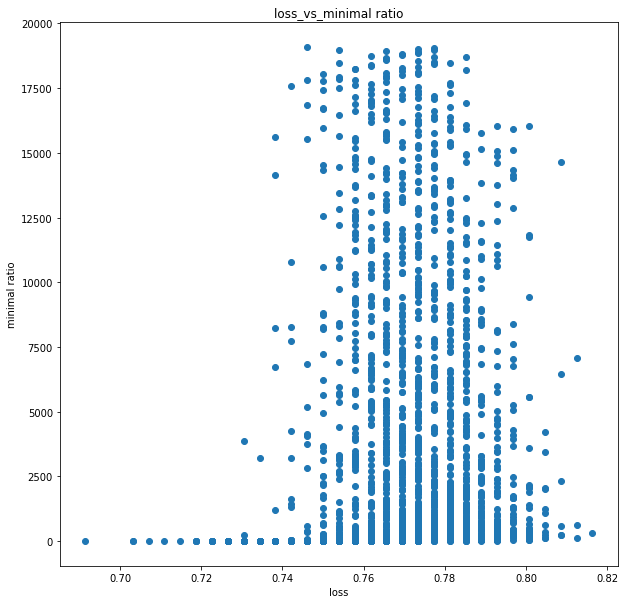

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(minimal_ratio_eps,value_losses_1)
plt.xlabel('loss')
plt.ylabel('minimal ratio')
plt.title('loss_vs_minimal ratio');
plt.plot()
plt.savefig("loss_vs_minimal ratio.png")